In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

***
# **FUNCTIONS**

In [3]:
#Creates a new trimmed file of the desired data file
#If desired, can delete a column from the file if this is not necessary for the final trimmed file
def trim_SSVEP_data(data_path, delete_col=None):
    new_lineas = []

    with open(data_path) as new_file:
        for index, linea in enumerate(new_file):
            
            if index > 4:
                linea_lista = linea.split("\t")
                
                if not delete_col == None and type(delete_col) != int:
                    print(f"If you want to delete a column from the file please enter a valid integer value [0 - {len(linea_lista)-1}]")
                    return -1
                elif not delete_col == None and delete_col >= len(linea_lista):
                    print(f"If you want to delete a column from the file please enter a valid integer value [0 - {len(linea_lista)-1}]")
                    return -1
                elif not delete_col == None:
                    del linea_lista[delete_col]
                
                if linea_lista[2] != "0":
                    string_linea = ""
                    linea_lista[1] = str(int(float(linea_lista[1].rsplit("e+12", 1)[0])*math.pow(10, 12)))

                    for dato in linea_lista:
                        if not dato == "\n":
                            string_linea += dato + "\t"
                        else:
                            string_linea += dato
                    new_lineas.append(string_linea)
    
    path_index = data_path.rfind("\\") + 1
    new_file_name = data_path[path_index:].split(".")
    
    data_file = data_path[0:path_index] + new_file_name[0] + "_trimmed." + new_file_name[1]
    final_file = open(data_file, "w")
    final_file.writelines(new_lineas)
    final_file.close()

In [4]:
#Creates a new trimmed file of the desired eye tracker file
def trim_webGazer_data(data_path):
    new_lineas = []

    with open(data_path) as new_file:
        for index, linea in enumerate(new_file):

            if index > 1:
                linea_lista = linea.split(" ")
                del linea_lista[0]
                del linea_lista[1]
                del linea_lista[2]
                
                linea_lista[2] = linea_lista[2].rsplit("\n", 1)[0]

                string_linea = ""
                for dato in range(len(linea_lista)):
                    if dato != 2:
                        string_linea += linea_lista[dato] + "\t"
                    else:
                        string_linea += linea_lista[dato] + "\t\n"
                new_lineas.append(string_linea)

    path_index = data_path.rfind("\\") + 1
    new_file_name = data_path[path_index:].split(".")

    data_file = data_path[0:path_index] + new_file_name[0] + " trimmed." + new_file_name[1]
    final_file = open(data_file, "w")
    final_file.writelines(new_lineas)
    final_file.close()

In [5]:
#Gets the centroids of the gaze for each mark
#Receives as inputs the path of the file with the data from the experiment and the path of the file with the positions of the gaze

#RETURNS 2 LISTS

#1. Returns a list of 5 lists (representing the marks 101-105), each having a x list and y list, representing 8 points per mark
#2. Returns a list of 40 lists containing each the points gazed by webgazer, the timestamps of each point and the selected stimulus during that lapse of time.
#   Can be used in function get_stimulus_time_gaze
def get_marks_centroids(experiment_file, positions_file=None):
   
    stages = []
    with open(experiment_file) as exp:
        for line in exp:
            line_list = line.split("\t")

            if 101 <= int(line_list[2]) <= 200:
                del line_list[3]
                line_list[1] = int(line_list[1])
                stages.append(line_list)

    stages_pointer = 0
    positions = []
    with open(positions_file) as pos:
        collect_data = False

        for line in pos:
            if stages_pointer >= len(stages):
                break

            line_list = line.split("\t")

            x = float(line_list[0])
            y = float(line_list[1])
            time = int(line_list[2])
            time_stages = stages[stages_pointer][1]
            del line_list[3]

            if not collect_data and time > time_stages:
                positions.append([[x], [y], [time], stages[stages_pointer][2]])
                collect_data = True
                stages_pointer += 1

            elif collect_data == True and time < time_stages:
                positions[int(stages_pointer/2)][0].append(x)
                positions[int(stages_pointer/2)][1].append(y)
                positions[int(stages_pointer/2)][2].append(time)
            
            elif collect_data == True and time > time_stages:
                collect_data = False
                stages_pointer += 1
    
    marks_centroids =[[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]]
    for stimulus in range(len(positions)):
        center_x = sum(positions[stimulus][0])/len(positions[stimulus][0])
        center_y = sum(positions[stimulus][1])/len(positions[stimulus][1])
        mark = positions[stimulus][3]

        if mark == "101":
            marks_centroids[0][0].append(center_x)
            marks_centroids[0][1].append(center_y)
        elif mark == "102":
            marks_centroids[1][0].append(center_x)
            marks_centroids[1][1].append(center_y)
        elif mark == "103":
            marks_centroids[2][0].append(center_x)
            marks_centroids[2][1].append(center_y)
        elif mark == "104":
            marks_centroids[3][0].append(center_x)
            marks_centroids[3][1].append(center_y)
        else:
            marks_centroids[4][0].append(center_x)
            marks_centroids[4][1].append(center_y)

    return marks_centroids, positions

In [17]:
#Plots the centroids of the points passed. Needs the 1st output list of get_marks_centroids
def plot_centroids(marks_centroids, title="", plot_stimulus=False):
    set_title = ""
    if title == "":
        set_title = "Gaze data of the experiment"
    else:
        set_title = str(title)

    x_coordinates = []
    y_coordinates = []
    mean_x = []
    mean_y = []

    for mark in range(len(marks_centroids)):
        
        for axis in range(len(marks_centroids[mark])):
            n_points = len(marks_centroids[mark][axis])
            
            if axis == 0:
                mean_x.append(sum(marks_centroids[mark][axis])/n_points)
            else:
                mean_y.append((sum(marks_centroids[mark][axis])+103*n_points)/n_points)
            
            for data in range(len(marks_centroids[mark][axis])):
                if axis == 0:
                    x_coordinates.append(marks_centroids[mark][axis][data])
                else:
                    y_coordinates.append(marks_centroids[mark][axis][data]+103)

    fig = plt.figure()
    fig.set_facecolor("0.9")

    plt.xlim(0, 1920)
    plt.ylim(1080-(40+18+120)-(40+25), 0)

    plt.title(set_title)
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.scatter(x_coordinates[0:7], y_coordinates[0:7], color='green')
    plt.scatter(x_coordinates[8:15], y_coordinates[8:15], color='black')
    plt.scatter(x_coordinates[16:23], y_coordinates[16:23], color='purple')
    plt.scatter(x_coordinates[24:31], y_coordinates[24:31], color='grey')
    plt.scatter(x_coordinates[32:39], y_coordinates[32:39])
    plt.scatter(mean_x, mean_y, color='red');

    if plot_stimulus:
        x_points = [660, 960, 1260, 960, 960]
        y_points = [484, 184, 484, 784, 484]
        plt.scatter(x_points, y_points, color='orange')

    plt.show()

    return None

In [7]:
#Gets the average time that webgazer needed to focus inside each stimulus area
#Change acceptance_rate [0-1] to select how strict the gaze rate focus should be (focus_points/n_points for each window of points)
#Change window_len [1~60] to select how many points will be evauated for the gaze rate focus

#RETURNS 2 LISTS
#1. Returns a list containing the average time in ms that webgazer needed to focus inside each stimulus area and the average of all 5 of this times (only averages times != 0)
#2. Returns a lits containing how many times webgazer was able to focus inside each stimulus
from cmath import nan


def get_stimulus_time_gaze(data, acceptance_rate=0.7, window_len=10):
    if not type(data) == list:
        print("Please enter a valid data input. List of shape (40, 4) from get_marks_centroids")
        return -1
    elif not len(data) == 40 and not 101 <= int(data[0][3]) <= 105:
        print("Please enter a valid data input. List of shape (40, 4) from get_marks_centroids")
        return -1
    
    #Each array inside stimulus_limit indicates --> [x_left, y_up, x_right, y_down] of the vertices of the stimulus
    stimulus_limit = {"101":[600, 424, 720, 544], 
                      "102":[900, 124, 1020, 244],
                      "103":[1200, 424, 1320, 544],
                      "104":[900, 724, 720, 844],
                      "105":[900, 424, 1020, 544]}
    avg_stimulus_time_gaze = np.zeros(5)
    
    n_acceptances = np.full(5, 8)

    for mark in range(len(data)):
        
        local_window_len = int(window_len)
        if len(data[mark][0]) <= local_window_len:
            print(f"Parameter window_len was too large for number of points {data[mark][0]} in mark {mark}, setting window_len to number of points\n")
            local_window_len = len(data[mark][0])
        elif local_window_len <= 0:
            print(f"Parameter window_len is too small, please select a window_len of at least 1")
            return -1

        for init_window in range(len(data[mark][0])):
            end_window = init_window + local_window_len
            stimulus_index = list(stimulus_limit).index(data[mark][3])
            
            if end_window >= len(data[mark][0]):
                n_acceptances[stimulus_index] -= 1
                break

            x_windowed = data[mark][0][init_window:end_window]
            y_windowed = data[mark][1][init_window:end_window]
            limits = stimulus_limit.get(data[mark][3])
            local_acc_rate = 0
            
            for x, y in zip(x_windowed, y_windowed):
                if limits[0] <= x <= limits[2] and limits[1] <= y+103 <= limits[3]:
                    local_acc_rate += 1
            
            local_acc_rate /= local_window_len
            if local_acc_rate >= acceptance_rate:
                avg_time = data[mark][2][end_window] - data[mark][2][0]
                avg_stimulus_time_gaze[stimulus_index] += avg_time
                break
    
    avg_stimulus_time_gaze = np.divide(avg_stimulus_time_gaze, n_acceptances)

    avg_time_general = 0
    not_zeros = 0
    for time in avg_stimulus_time_gaze:
        if not time == nan:
            avg_time_general += time
            not_zeros += 1
    
    if not not_zeros == 0:
        avg_time_general /= not_zeros
    
    avg_stimulus_time_gaze = list(avg_stimulus_time_gaze)
    avg_stimulus_time_gaze.append(avg_time_general)
    n_acceptances = list(n_acceptances)

    return avg_stimulus_time_gaze, n_acceptances

***
### Run to trim and get the time and timestamp of the marks from the **data** files

- Change the `path` to get the correct data file trimmed

- Change the `delete_col` for eliminating the desired column

In [7]:
trim_SSVEP_data("D:\\eye-tracker\\Webgazer data\\S1\\data_mOO.txt", delete_col=2)
trim_SSVEP_data("D:\\eye-tracker\\Webgazer data\\S1\\data_mCB.txt")

***
### Run to trim the **eye tracker** files

- Change the `path` to get the correct data file trimmed

In [8]:
trim_webGazer_data("D:\\eye-tracker\\Webgazer data\\S1\\eye tracker mOO.txt")
trim_webGazer_data("D:\\eye-tracker\\Webgazer data\\S1\\eye tracker mCB.txt")

***
### Run to plot the centroids of the gazes throghout the experiment

- Change the `experiment_file` to get the data from the desired experiment

- Change the `positions_file` to get the data from the desired eye tracker file

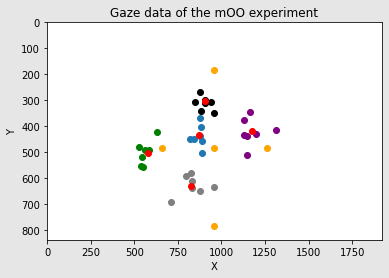

In [21]:
marks_pos, positions = get_marks_centroids("D:\\eye-tracker\\Webgazer data\\S1\\data_mOO_trimmed.txt", "D:\\eye-tracker\\Webgazer data\\S1\\eye tracker mOO trimmed.txt")
plot_centroids(marks_pos, "Gaze data of the mOO experiment", plot_stimulus=True)

In [22]:
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.6)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.8)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.9)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 1.0)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")

Avg response time per mark: [1229.0, 1988.0, 3405.0, nan, 3027.0, nan] ms
Valid focused gazes per mark: [3, 1, 3, 0, 4]

Avg response time per mark: [1258.6666666666667, 2072.0, 883.0, nan, 2889.3333333333335, nan] ms
Valid focused gazes per mark: [3, 1, 1, 0, 3]

Avg response time per mark: [1344.6666666666667, 2159.0, nan, nan, 3373.6666666666665, nan] ms
Valid focused gazes per mark: [3, 1, 0, 0, 3]

Avg response time per mark: [1434.6666666666667, 2246.0, nan, nan, 3665.0, nan] ms
Valid focused gazes per mark: [3, 1, 0, 0, 3]

Avg response time per mark: [1490.3333333333333, 2330.0, nan, nan, 3868.5, nan] ms
Valid focused gazes per mark: [3, 1, 0, 0, 2]



C:\Users\Kaiko99\AppData\Local\Temp\ipykernel_34028\1135402372.py:62: RuntimeWarning: invalid value encountered in true_divide
  avg_stimulus_time_gaze = np.divide(avg_stimulus_time_gaze, n_acceptances)


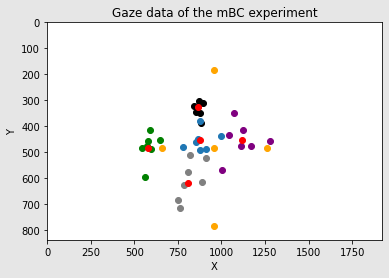

In [23]:
marks_pos, positions = get_marks_centroids("D:\\eye-tracker\\Webgazer data\\S1\\data_mCB_trimmed.txt", "D:\\eye-tracker\\Webgazer data\\S1\\eye tracker mCB trimmed.txt")
plot_centroids(marks_pos, "Gaze data of the mBC experiment", plot_stimulus=True)


In [24]:
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.6)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.8)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 0.9)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")
avg_response_time, on_focus_gazes = get_stimulus_time_gaze(positions, 1.0)
print(f"Avg response time per mark: {avg_response_time} ms\nValid focused gazes per mark: {on_focus_gazes}\n")

Avg response time per mark: [848.6666666666666, nan, 2586.5, nan, 1085.75, nan] ms
Valid focused gazes per mark: [3, 0, 2, 0, 4]

Avg response time per mark: [874.3333333333334, nan, 2669.0, nan, 1262.0, nan] ms
Valid focused gazes per mark: [3, 0, 2, 0, 3]

Avg response time per mark: [1384.0, nan, 2333.0, nan, 1697.3333333333333, nan] ms
Valid focused gazes per mark: [3, 0, 1, 0, 3]

Avg response time per mark: [2078.0, nan, 2416.0, nan, 1888.3333333333333, nan] ms
Valid focused gazes per mark: [3, 0, 1, 0, 3]

Avg response time per mark: [1642.5, nan, 2495.0, nan, 2022.3333333333333, nan] ms
Valid focused gazes per mark: [2, 0, 1, 0, 3]



C:\Users\Kaiko99\AppData\Local\Temp\ipykernel_34028\1135402372.py:62: RuntimeWarning: invalid value encountered in true_divide
  avg_stimulus_time_gaze = np.divide(avg_stimulus_time_gaze, n_acceptances)


***
INFORMATION

This plot shows the **centers of the stimulus of the experiment** as red dots.

Also, a **scatter of the gazes of the selected experiment**, where: `{black = left, grey = up, orange = right, green = down, blue = center}`

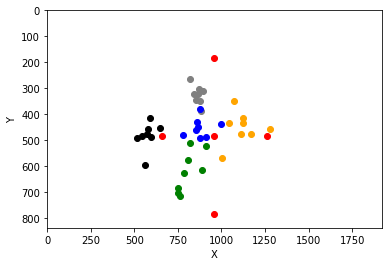

In [67]:
info, positions = get_marks_centroids("D:\\eye-tracker\\Webgazer data\\S1\\data_mCB_trimmed.txt", "D:\\eye-tracker\\Webgazer data\\S1\\eye tracker mCB trimmed.txt")

x_points = [660, 960, 1260, 960, 960]
y_points = [484, 184, 484, 784, 484]

plt.xlim(0, 1920)
plt.ylim(1080-(40+18+120)-(40+25), 0)
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(x_points, y_points, color='red')
plt.scatter(info[0][0], np.array(info[0][1]) + (103*len(info[0][1]))/len(info[4][1]), color='black')
plt.scatter(info[1][0], np.array(info[1][1]) + (103*len(info[1][1]))/len(info[4][1]), color='grey')
plt.scatter(info[2][0], np.array(info[2][1]) + (103*len(info[4][1]))/len(info[2][1]), color='orange')
plt.scatter(info[3][0], np.array(info[3][1]) + (103*len(info[3][1]))/len(info[4][1]), color='green')
plt.scatter(info[4][0], np.array(info[4][1]) + (103*len(info[4][1]))/len(info[4][1]), color='blue')
plt.show()